# Homework 4: Clustering

Assigned 4/19

Due 5/3 11:59pm

105 points

This homework covers the data and clustering modules.  There is one problem (4.2) on PLS that will be covered in the first feature engineering lecture

## 1. Python PubChem API (20 points)

Write a function that takes an arbitrary chemical name or CAS number as an input and returns the number of C-H bonds in the compound. **Use your function to determine the number of C-H bonds in palmitic acid**.

In [91]:
from pubchempy import get_compounds

# Define a function that takes a name or CAS number as input
def get_CH_bonds(name_or_cas):
    compounds = get_compounds(name_or_cas, 'name')
    if not compounds:
        compounds = get_compounds(name_or_cas, 'xref/registry_id')
    if not compounds:
        return None
    compound = compounds[0]
    atoms = compound.atoms
    bonds = compound.bonds
    CH_bonds = 0
    for bond in bonds:
        aid1 = bond.aid1
        aid2 = bond.aid2
        symbol1 = atoms[aid1 - 1].element
        symbol2 = atoms[aid2 - 1].element
        if (symbol1 == 'C' and symbol2 == 'H') or (symbol1 == 'H' and symbol2 == 'C'):
            CH_bonds += 1
    return CH_bonds


In [92]:
get_CH_bonds("palmitic acid")

31

## 2. Comparing PCA, kernel PCA, and tSNE low-dimensional representations  (15 pts)

Here, you will use three different unsupervised methods to create low-dimensional representations of the MNIST dataset and perform clustering on the different results.


In [93]:
%matplotlib inline
import pylab as plt
import numpy as np
import pandas as pd
from scipy.stats import norm
from sklearn.datasets import load_digits

digits = load_digits()
print("Digits data shape: {}".format(digits.data.shape))
print("Digits output shape: {}".format(digits.target.shape))
X_mnist = np.array(digits.data)
y_mnist = np.array(digits.target)

Digits data shape: (1797, 64)
Digits output shape: (1797,)


In [94]:
def show_image(digit_data, n, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = digit_data[n].reshape(8,8)
    ax.imshow(img,cmap='binary')    

In [95]:
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

### 2.1 Use PCA, kernel PCA (kPCA), and tSNE to decompose the MNIST dataset to two features. 

Wall time: 146 ms


c:\Users\Gabriel Lawrence\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Gabriel Lawrence\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Wall time: 3.62 s


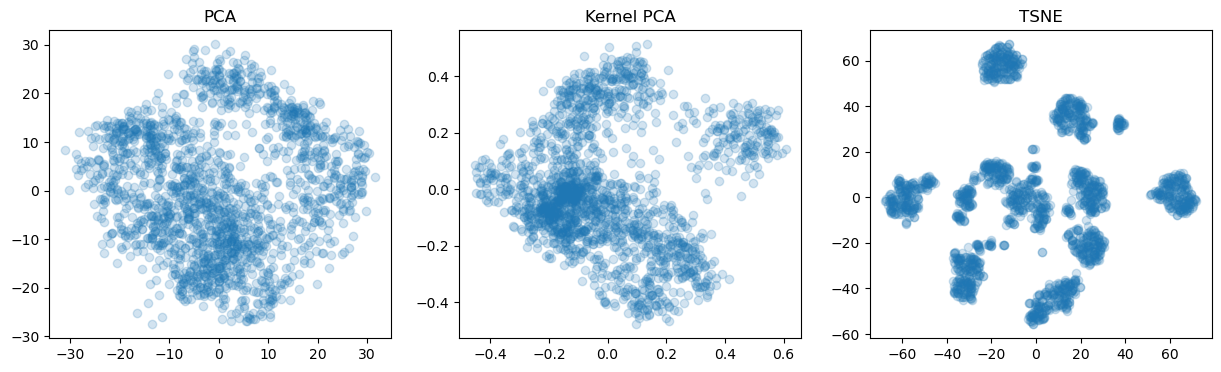

In [116]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, TSNE

n_components = 2

pca = PCA(n_components = n_components)
%time X_pca = pca.fit_transform(X_mnist)

kpca = KernelPCA(n_components = n_components, kernel='rbf', gamma=0.001)
%time X_kpca = kpca.fit_transform(X_mnist)

tsne = TSNE(n_components = n_components)
%time X_tsne = tsne.fit_transform(X_mnist)

fig, axes = plt.subplots(1,3, figsize = (15,4))
data = [X_pca, X_kpca, X_tsne]
labels = ['PCA', 'Kernel PCA', 'TSNE']
for X_i, label, ax in zip(data, labels,axes):
    ax.scatter(X_i[:,0], X_i[:,1], alpha=0.2)
    ax.set_title(label)

### 2.2 Now, use k-means clustering to attempt to identify 10 clusters for each case, and plot the results as we did in lecture notebook 5.3. 

In [97]:
def dist(pt1, pt2):
    "Euclidean distance between two points"
    #note that this can also be performed with np.linalg.norm(pt1-pt2)
    return np.sqrt(sum([(xi-yi)**2 for xi, yi in zip(pt1, pt2)]))

def expected_assignment(pt, cluster_centers):
    # Expectation: find the closest points to each cluster center
    dists = [dist(pt,ci) for ci in cluster_centers] #<- find distance to each center
    min_index = dists.index(min(dists)) #<- find the index (cluster) with the minimum dist
    return min_index

def new_centers(cluster_points, centers):
    # Maximization: maximize the proximity of centers to points in a cluster
    centers = list(centers)
    for i,ci in enumerate(cluster_points):
        if ci != []:
            centers[i] = np.mean(ci, axis=0)
    return centers

(1797, 2)


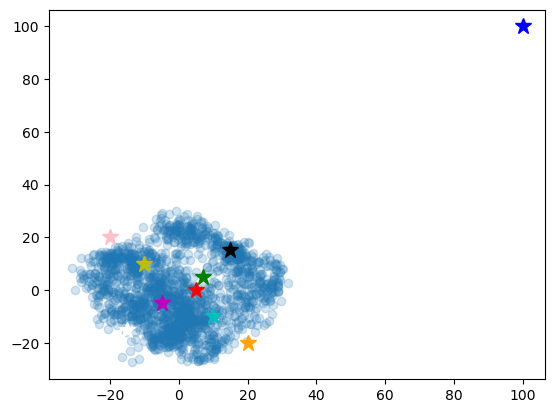

In [98]:
X = X_pca #we are providing X_pca from a 2-component PCA model
print(X.shape)

#cluster_centers = ([-0.5,0], [0.5,0]) #a 2-center initial guess may produce a better result
#cluster_centers = ([5,0], [7,5], [100,100]) #3 center locations guessed; stars in the figure define the centers guessed
cluster_centers = ([5,0], [7,5], [100,100], [-5,-5], [10,-10], [-10,10], [15,15], [-15,-15], [20,-20], [-20,20]) #10 center locations guessed; stars in the figure define the centers guessed
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], alpha=0.2)
colors = {0:'r', 1:'g', 2:'b', 3:'m', 4:'c', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'pink'}
for i,ci in enumerate(cluster_centers):
    ax.plot(ci[0], ci[1], marker='*', markersize='12', color=colors[i])

[ 3.53012023 -1.48173311]
[10.59115138  5.45802267]
[100, 100]
[-5.40523809 -6.12422298]
[  8.85708435 -11.61749039]
[-11.39930984  10.34043182]
[15.38823245 13.75977949]
[-11.81054762 -13.39952999]
[ 14.60127172 -18.56333988]
[-19.63376108  13.38975151]


Text(0, 0.5, 'PC2')

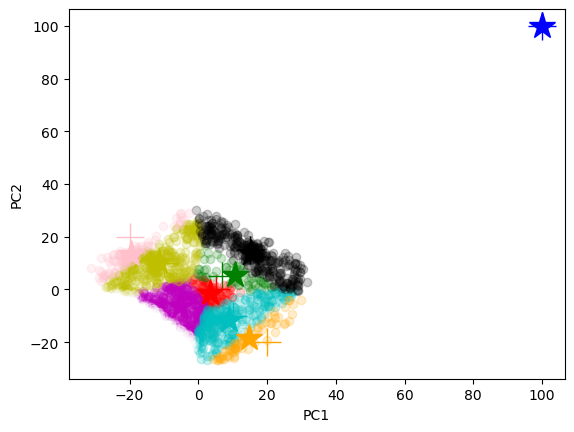

In [99]:
fig, ax = plt.subplots()
# Plot old centers
for i,ci in enumerate(cluster_centers):                                 # stars represent the current centers
    ax.plot(ci[0], ci[1], marker='+', markersize='20', color=colors[i]) # +s are where the centers were in the prior round
    
# Which cluster do we "expect" each point to belong to?
clusters = [[],[],[],[],[],[],[],[],[],[]] # 10 Clusters!
for pt in X:
    cluster_idx = expected_assignment(pt, cluster_centers)
    clusters[cluster_idx].append(pt)
    
# What centers best represent these new assignments?
cluster_centers = new_centers(clusters, cluster_centers)

# Plot new assignments
for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker='o', color=colors[i], alpha=0.2)
        
# Plot new centers
for i,ci in enumerate(cluster_centers):
    print(ci)
    ax.plot(ci[0], ci[1], marker='*', markersize='20', color=colors[i])
    
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

(1797, 2)


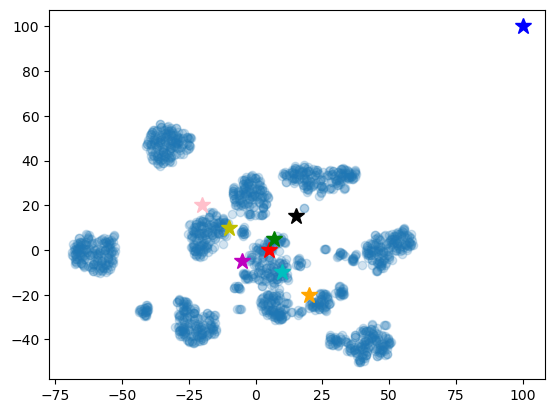

In [100]:
X = X_tsne #we are providing X_pca from a 2-component PCA model
print(X.shape)

#cluster_centers = ([-0.5,0], [0.5,0]) #a 2-center initial guess may produce a better result
#cluster_centers = ([5,0], [7,5], [100,100]) #3 center locations guessed; stars in the figure define the centers guessed
cluster_centers = ([5,0], [7,5], [100,100], [-5,-5], [10,-10], [-10,10], [15,15], [-15,-15], [20,-20], [-20,20]) #10 center locations guessed; stars in the figure define the centers guessed
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], alpha=0.2)
colors = {0:'r', 1:'g', 2:'b', 3:'m', 4:'c', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'pink'}
for i,ci in enumerate(cluster_centers):
    ax.plot(ci[0], ci[1], marker='*', markersize='12', color=colors[i])

[ 3.6166356  -0.42585504]
[6.825452  6.3226204]
[100, 100]
[-1.5833331 -8.611945 ]
[  7.4902563 -13.384567 ]
[-12.394317  11.082537]
[27.22834  24.592941]
[-31.806135 -24.768152]
[ 34.60832  -25.393126]
[-37.612743  27.020168]


Text(0, 0.5, 'PC2')

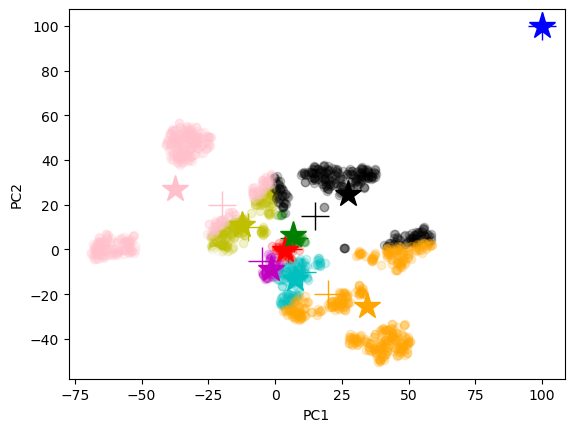

In [101]:
fig, ax = plt.subplots()
# Plot old centers
for i,ci in enumerate(cluster_centers):                                 # stars represent the current centers
    ax.plot(ci[0], ci[1], marker='+', markersize='20', color=colors[i]) # +s are where the centers were in the prior round
    
# Which cluster do we "expect" each point to belong to?
clusters = [[],[],[],[],[],[],[],[],[],[]] # 10 Clusters!
for pt in X:
    cluster_idx = expected_assignment(pt, cluster_centers)
    clusters[cluster_idx].append(pt)
    
# What centers best represent these new assignments?
cluster_centers = new_centers(clusters, cluster_centers)

# Plot new assignments
for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker='o', color=colors[i], alpha=0.2)
        
# Plot new centers
for i,ci in enumerate(cluster_centers):
    print(ci)
    ax.plot(ci[0], ci[1], marker='*', markersize='20', color=colors[i])
    
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

(1797, 2)


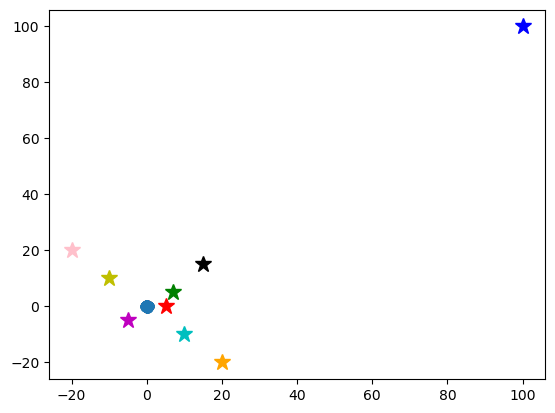

In [102]:
X = X_kpca #we are providing X_pca from a 2-component PCA model
print(X.shape)

#cluster_centers = ([-0.5,0], [0.5,0]) #a 2-center initial guess may produce a better result
#cluster_centers = ([5,0], [7,5], [100,100]) #3 center locations guessed; stars in the figure define the centers guessed
cluster_centers = ([5,0], [7,5], [100,100], [-5,-5], [10,-10], [-10,10], [15,15], [-15,-15], [20,-20], [-20,20]) #10 center locations guessed; stars in the figure define the centers guessed
fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], alpha=0.2)
colors = {0:'r', 1:'g', 2:'b', 3:'m', 4:'c', 5:'y', 6:'k', 7:'w', 8:'orange', 9:'pink'}
for i,ci in enumerate(cluster_centers):
    ax.plot(ci[0], ci[1], marker='*', markersize='12', color=colors[i])

[ 2.90336913e-17 -1.01826434e-16]
[7, 5]
[100, 100]
[-5, -5]
[10, -10]
[-10, 10]
[15, 15]
[-15, -15]
[20, -20]
[-20, 20]


Text(0, 0.5, 'PC2')

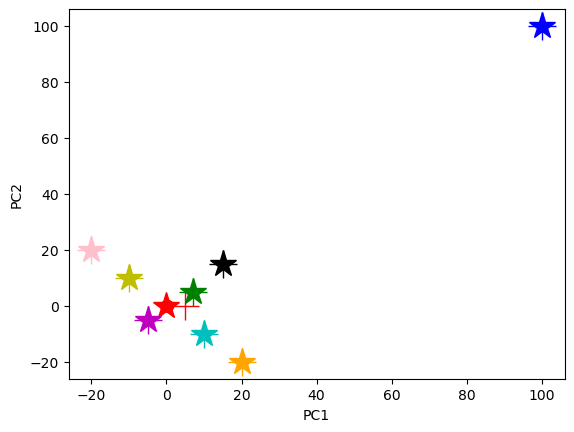

In [103]:
fig, ax = plt.subplots()
# Plot old centers
for i,ci in enumerate(cluster_centers):                                 # stars represent the current centers
    ax.plot(ci[0], ci[1], marker='+', markersize='20', color=colors[i]) # +s are where the centers were in the prior round
    
# Which cluster do we "expect" each point to belong to?
clusters = [[],[],[],[],[],[],[],[],[],[]] # 10 Clusters!
for pt in X:
    cluster_idx = expected_assignment(pt, cluster_centers)
    clusters[cluster_idx].append(pt)
    
# What centers best represent these new assignments?
cluster_centers = new_centers(clusters, cluster_centers)

# Plot new assignments
for i, ci in enumerate(clusters):
    for pt in ci:
        ax.plot(pt[0], pt[1], marker='o', color=colors[i], alpha=0.2)
        
# Plot new centers
for i,ci in enumerate(cluster_centers):
    print(ci)
    ax.plot(ci[0], ci[1], marker='*', markersize='20', color=colors[i])
    
    
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

### 2.3 Comment on whether or not any of these methods seems to be better than others at identifying 10 clusters.

Initially, I believed that TNSE would provide the best results for identifying 10 clusters, however upon further analysis, implementation and visual inspection, I found that kPCA provided the best clustering results, which was quite surprising as I believed that TNSE's seperation between groups would yield the best results. However, I found based on results above, that kPCA did provide the best clustering results with the clearest separation between groups.

## 3.1 Finding a representative from low dimensional representations. (10 points)

Find the "average" 10-dimensional vector for an "8". Use PCA to project the MNIST data onto 10 dimensions, then select the points labeled as 8 and take the average. Visualize the resulting average vector as an 8x8 image.

In [104]:
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()
print("Digits data shape: {}".format(digits.data.shape))
print("Digits output shape: {}".format(digits.target.shape))
X_mnist = np.array(digits.data)
y_mnist = np.array(digits.target)

Digits data shape: (1797, 64)
Digits output shape: (1797,)


In [105]:
def show_image(digit_data, n, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = digit_data[n].reshape(8,8)
    ax.imshow(img,cmap='binary')    

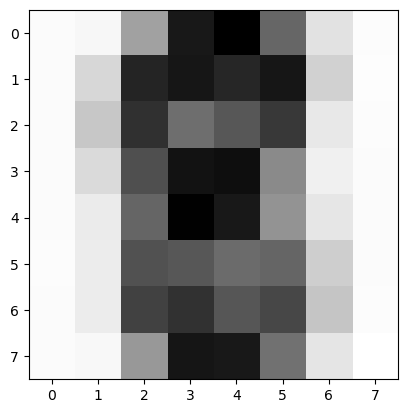

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Project the MNIST data onto 10 dimensions using PCA
pca = PCA(n_components=10)
pca.fit(X_mnist)
digits_pca = pca.transform(X_mnist)

# Select the points labeled as 8
eights = digits_pca[y_mnist == 8]

# Take the average of the eights
average_eight = np.mean(eights, axis=0)
average_eightstep2 = average_eight.reshape(1,-1)
average_eighttrans = pca.inverse_transform(average_eightstep2)

show_image(average_eighttrans, 0)

## 3.2 Determining the number of clusters. (10 points)

**Plot** the silhouette score as a function of number of clusters for a GMM model on the PCA dataset you constructed in 2.1. Use `full` covariance, and return a plot with number of clusters ($k$) along the $x$ axis and silhouette score along the $y$ axis.

Wall time: 5.71 ms


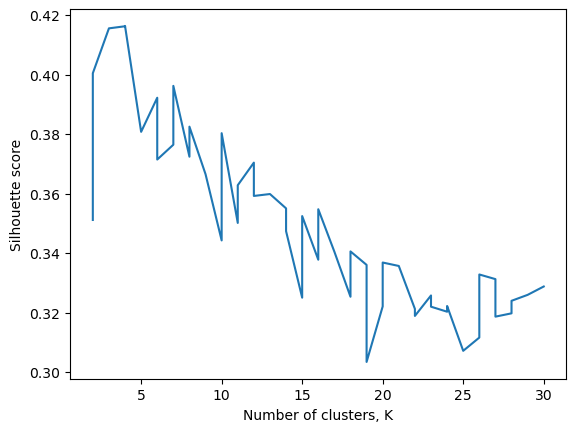

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

n_clusters_range = np.linspace(2, 30, dtype = "int64")
n_components = 2
pca = PCA(n_components = n_components)
%time X_reduced = pca.fit_transform(X_mnist)

# Create a list of silhouette scores for different numbers of clusters.
silhouette_scores = []
for n_clusters in n_clusters_range:
  gmm = GaussianMixture(n_components=n_clusters, covariance_type="full")
  gmm.fit(X_reduced)
  silhouette_scores.append(silhouette_score(X_reduced, gmm.predict(X_reduced)))

plt.plot(n_clusters_range, silhouette_scores)
plt.xlabel("Number of clusters, K")
plt.ylabel("Silhouette score")
plt.show()

## 3.3 Generative model for handwritten digits (10 points)

**Create** a GMM that can generate new examples of the digit 6.  Follow the same procedures given in the "Generative Models" lecture, but only use input data from the digit 6. You can use the `y_mnist` variable to quickly select this subset (`y_mnist == 6`), and you **should use the BIC** to optimize the number of Gaussians needed. **Show** (visually) an example of a synthetic "6" generated by your model.

c:\Users\Gabriel Lawrence\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Gabriel Lawrence\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


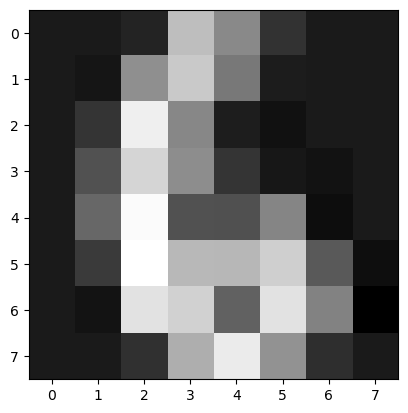

In [140]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.mixture import GaussianMixture

digits = load_digits()
y_mnist = digits['target'] == 6
X_mnist = digits['data'][y_mnist]

# Construct several BICs, select the best one.
bic_scores = []
for n_components in range(1, 10):
    gmm = GaussianMixture(n_components=n_components)
    gmm.fit(X_mnist)
    bic_scores.append(gmm.bic(X_mnist))
n_components = np.argmin(bic_scores) + 1

# Take the best BIC, then apply it to a Gaussianmixture.
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X_mnist)
sample = gmm.sample(1)[0] # 0 Works, I guess.

#Show Image
image = sample.reshape(8, 8)
plt.imshow(image, cmap='gray')
plt.show()

## 4.1 Density based clustering (15 points)

Load the Dow data set, rescaling the features and taking every fifth data point (I have done this for you). **Use** the kernel PCA (kPCA) decomposition of the Dow dataset with a RBF kernel to reduce the dataset to two features. **Use** the `scikit-learn` implementation of the mean shift algorithm  and **vary** the bandwidth in the range  [0.01, 0.05, 0.1, 0.2, 0.3].  **Plot** the silhouette score as a function of bandwidth for the mean shift algorithm.  **Plot** the clustering results of your best model (see lecture for examples).

In [141]:
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as plt

df = pd.read_excel('impurity_dataset-training.xlsx')
def is_real_and_finite(x):
    if not np.isreal(x):
        return False
    elif not np.isfinite(x):
        return False
    else:
        return True

all_data = df[df.columns[1:]].values #drop the first column (date)
numeric_map = df[df.columns[1:]].applymap(is_real_and_finite)
real_rows = numeric_map.all(axis=1).copy().values #True if all values in a row are real numbers
X_dow = np.array(all_data[real_rows,:-5], dtype='float') #drop the last 5 cols that are not inputs
y_dow = np.array(all_data[real_rows,-3], dtype='float')
y_dow = y_dow.reshape(-1,1)
print(X_dow.shape, y_dow.shape)

(10297, 40) (10297, 1)


In [142]:
X = (X_dow - X_dow.mean(axis=0))/X_dow.std(axis=0)
X = X[::5] # take every 5th datapoint
print(X.shape)
Y = (y_dow - y_dow.mean(axis=0))/y_dow.std(axis=0)
Y = Y[::5] # take every 5th datapoint
print(Y.shape)

(2060, 40)
(2060, 1)


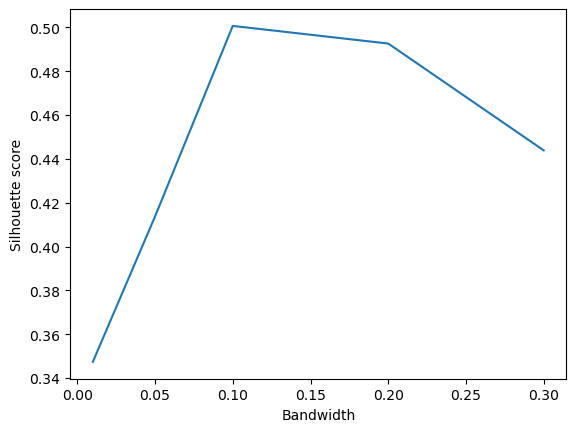

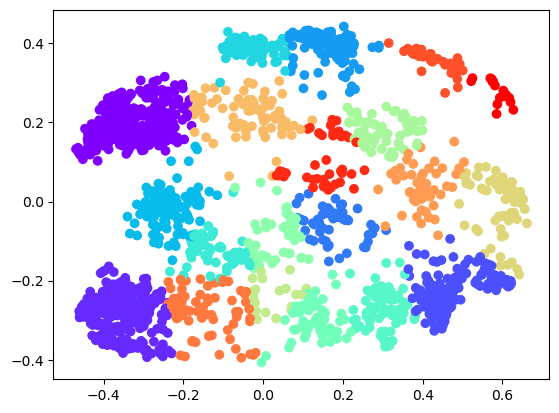

In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import KernelPCA
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score

# Use the kernel PCA (kPCA) decomposition of the Dow dataset with a RBF kernel to reduce the dataset to two features.
kpca = KernelPCA(n_components=2, kernel='rbf')
X_reduced = kpca.fit_transform(X)
bandwidths = [0.01, 0.05, 0.1, 0.2, 0.3]

# Use the `scikit-learn` implementation of the mean shift algorithm  and **vary** the bandwidth in the range  [0.01, 0.05, 0.1, 0.2, 0.3]. 
silhouette_scores = []
for bandwidth in bandwidths:
  ms = MeanShift(bandwidth=bandwidth)
  ms.fit(X_reduced)
  silhouette_scores.append(silhouette_score(X_reduced, ms.labels_))

# Plot the silhouette scores.
plt.plot(bandwidths, silhouette_scores)
plt.xlabel("Bandwidth")
plt.ylabel("Silhouette score")
plt.show()

# Plot the clustering results of your best model.
best_bandwidth = bandwidths[np.argmax(silhouette_scores)]
ms = MeanShift(bandwidth=best_bandwidth)
ms.fit(X_reduced)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=ms.labels_, cmap='rainbow')
plt.show()

## 4.2 Partial Least Squares (15 points)

Use the partial least squares (PLS) algorithm and project the Dow data onto the first 5 PLS components. Create a kernel ridge regression (KRR) model based on (1) the first 5 PLS components and (2) the original data. For the KRR models use an `rbf` kernel and use GridSearchCV with 3-fold cross-validation to optimize `gamma = [0.1, 1, 10]` and `alpha = [0.001, 0.01, 0.1, 1, 10]`. **Report the score, Parity Plot, and optimal hyperparameters for the best KRR model in both cases.**

Score for KRR on original X: 0.9435935266774539
Optimal parameters for KRR on original X: {'alpha': 0.1, 'gamma': 0.1}


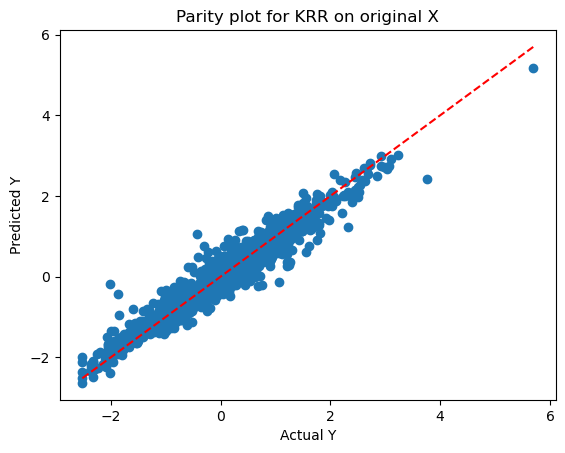

Score for KRR on PLS-transformed X: 0.7303820573439491
Optimal parameters for KRR on PLS-transformed X: {'alpha': 10, 'gamma': 0.1}


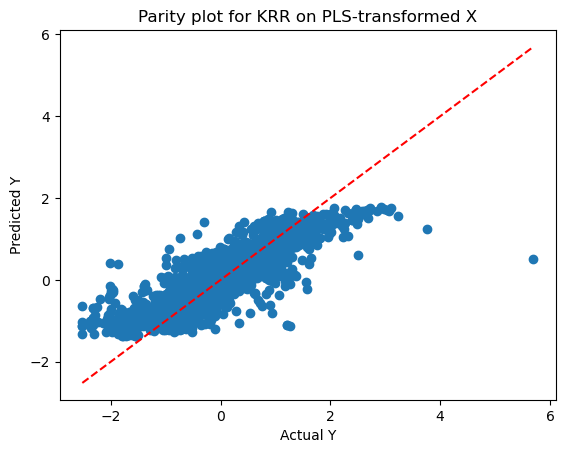

In [167]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Use PLS to project X onto the first 5 components
pls = PLSRegression(n_components=5)
X_pls = pls.fit_transform(X, Y)[0]

# Define the KRR model with rbf kernel and grid search parameters
krr = KernelRidge(kernel="rbf")
params = {"gamma": [0.1, 1, 10], "alpha": [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(krr, params, cv=3)
grid.fit(X, Y)
print("Score for KRR on original X:", grid.score(X, Y))
print("Optimal parameters for KRR on original X:", grid.best_params_)

# Plot the parity plot for KRR on original X
y_pred = grid.predict(X)
plt.scatter(Y, y_pred)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], "r--")
plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.title("Parity plot for KRR on original X")
plt.show()

# Fit the KRR model on the PLS-transformed X and report the score and optimal parameters
grid.fit(X_pls, Y)
print("Score for KRR on PLS-transformed X:", grid.score(X_pls, Y))
print("Optimal parameters for KRR on PLS-transformed X:", grid.best_params_)

# Plot the parity plot for KRR on PLS-transformed X
y_pred = grid.predict(X_pls)
plt.scatter(Y, y_pred)
plt.plot([Y.min(), Y.max()], [Y.min(), Y.max()], "r--")
plt.xlabel("Actual Y")
plt.ylabel("Predicted Y")
plt.title("Parity plot for KRR on PLS-transformed X")
plt.show()

## 5. (Graduate Only) Meaning of the correlation matrix (10 points)

**Show** that the correlation matrix is numerically equivalent to regression slopes between standardized features and that the square-value of the correlation matrix equals $R^2$ (*notice that this is only true when evaluated on the training data*). Use the Dow dataset, and select the first 4 features (`x1` through `x4`). Remember to standardize the data before computing the slopes. The goal is to show that `corr[i,j]` is equivalent to $m$ in $x_i = m x_j + b$, where $x_i$ and $x_j$ have been standardized. You will need to use `np.isclose` since there will be small numerical differences.

As the function below shows, the correlation matrix is numerically equivalent to regression slopes between standardized features, as every feature is equivalent to each other through isclose. 

In [173]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

df = pd.read_excel('impurity_dataset-training.xlsx')
X = df[["x1:Primary Column Reflux Flow", "x2:Primary Column Tails Flow", "x3:Input to Primary Column Bed 3 Flow", "x4:Input to Primary Column Bed 2 Flow"]].values

# Standardize, Clean, and Scale the data
imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
imputer.fit(X)
X = imputer.transform(X)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Compute the correlation matrix
corr = np.corrcoef(X_std.T)

# Loop over all pairs of features
for i in range(4):
  for j in range(4):
    if i != j: 
      # Fit a linear regression model between feature i and feature j
      lr = LinearRegression()
      lr.fit(X_std[:, i].reshape(-1, 1), X_std[:, j])
      m = lr.coef_[0]
      b = lr.intercept_
      # Get the R-squared score of the regression model
      r2 = lr.score(X_std[:, i].reshape(-1, 1), X_std[:, j])
      # Print the results and compare with the correlation matrix
      print(f"Feature {i+1} vs Feature {j+1}:")
      print(f"Correlation coefficient: {corr[i,j]}")
      print(f"Regression slope: {m}")
      print(f"Regression intercept: {b}")
      print(f"R-squared score: {r2}")
      print(f"Correlation coefficient is close to regression slope? {np.isclose(corr[i,j], m)}")
      print(f"Correlation coefficient squared is close to R-squared score? {np.isclose(corr[i,j]**2, r2)}")
      print()

Feature 1 vs Feature 2:
Correlation coefficient: 0.8252687502399082
Regression slope: 0.8252687502399085
Regression intercept: 3.3516280269324074e-16
R-squared score: 0.6810685101225405
Correlation coefficient is close to regression slope? True
Correlation coefficient squared is close to R-squared score? True

Feature 1 vs Feature 3:
Correlation coefficient: 0.6252866546668977
Regression slope: 0.6252866546668981
Regression intercept: 6.111889759653007e-17
R-squared score: 0.39098340050452085
Correlation coefficient is close to regression slope? True
Correlation coefficient squared is close to R-squared score? True

Feature 1 vs Feature 4:
Correlation coefficient: 0.7782083559732145
Regression slope: 0.7782083559732155
Regression intercept: 6.043355315614495e-16
R-squared score: 0.6056082453065351
Correlation coefficient is close to regression slope? True
Correlation coefficient squared is close to R-squared score? True

Feature 2 vs Feature 1:
Correlation coefficient: 0.82526875023990